In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.animation as animation

from IPython.display import display, HTML

css = """
<style>
    .jp-Notebook .jp-Cell {
        margin-bottom: 16px !important;
    }
</style>
"""

display(HTML(css))

**Future Todo**

1. Mathematical Quantity to explain the divergence behaviour between revenue and sales / transaction during holiday season
2. Why there are peaks and troughs in revenue/sales/transactions per day plot

In [2]:
df = pd.read_excel("Online Retail.xlsx")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


### CEO report 

#### First Question: How the business is doing? Is it great or bad?

Showing increase in revenue, transactions and atv

##### Seeing graphs

To answer this, i will show revenue per month first which includes returns thus CEO would understand
how much money the company is making per month and what is trend of this making money per month. There is
also trend of revenue per day.

<img src="monthly_revenue.png" alt="Monthly Revenue" width="600"/>

Here we can see that after the drop the revenue is increasing steadily even though it is holiday season (cuz gift shop)
the end is higher than 2010-12 revenue. Thus marking growth in business. Here 2011-12 is lower due to dataset recording sales
for 9 days which is 2011-12-01 to 2011-12-09

But if we look at daily revenue, the last day marked the highest recorded revenue

<img src="daily_revenue.png" alt="Daily Revenue" width="600"/>

Again if we want to look at growth, let's look at daily total transaction (total unique invoices). Here it total
transaction is increased from values from troughs.

<img src="daily_trx.png" alt="Daily Transactions" width="600"/>

Lastly let's look at combined transactions, sales (total quantity) and revenue per day polynomial plot.

<img src="comparison.png" alt="Comparison" width="600"/>

Here towards the end, the revenue has more slope than sales, thus saying that customer are buying pricier products.
This can be shown in ATV (Average Transaction Value) which is increasing.

<img src="monthly_atv.png" alt="Monthly ATV" width="600"/>

Showing that average revenue per transaction is increasing.

##### Total revenue generated

In [5]:
# total revenue including business expense and returns

df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
print('${:,.2f}'.format(df["TotalPrice"].sum()))

$9,747,747.93


##### Per Day Trend

In [46]:
# real sales per day

# with returns and without business things only product being sold or returned
real_sales = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

"""
real_sales = df[~(df["UnitPrice"] < 0)]
stock_series = real_sales["StockCode"]
stock_series = stock_series.astype(str)
real_sales = real_sales[stock_series.str.contains(r'\d', na=False)]
"""

summary = real_sales.groupby(df['InvoiceDate'].dt.date).agg(
    TotalTransactions=('InvoiceNo', 'nunique'),  # Count transactions
    TotalSales=('Quantity', 'sum'),          # Sum quantity sold
    TotalRevenue=('TotalPrice', 'sum')       # Sum total revenue
).reset_index()

summary['Days'] = summary['InvoiceDate'].apply(lambda x: x.toordinal())

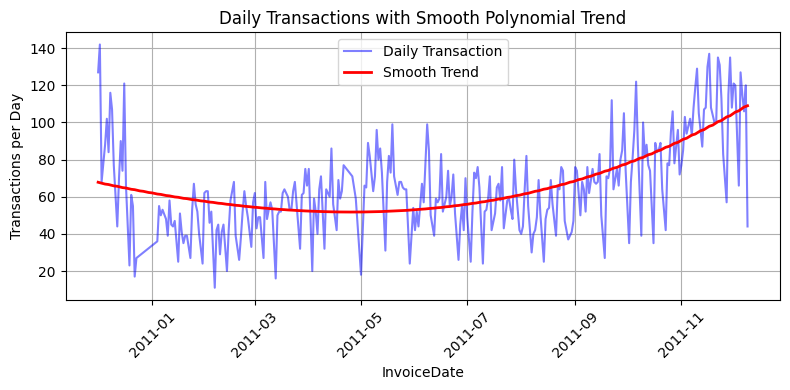

In [52]:
# plotting transaction per day

plt.figure(figsize=(8, 4))

# Fit a polynomial (e.g., degree 3 for a cubic polynomial)
degree = 3  # You can adjust the degree for more or less smoothness
trx_coef = np.polyfit(summary['Days'], summary['TotalTransactions'], degree)

# Create a smooth curve using the polynomial
smooth_days = np.linspace(summary['Days'].min(), summary['Days'].max(), 300)
smooth_trx = np.polyval(trx_coef, smooth_days)

# Convert smooth_days back to datetime for plotting
smooth_dates = [pd.Timestamp.fromordinal(int(day)) for day in smooth_days]

# Plot the original data
plt.plot(summary['InvoiceDate'], summary['TotalTransactions'], label='Daily Transaction', color='blue', alpha=0.5)

# Plot the smooth polynomial curve
plt.plot(smooth_dates, smooth_trx, label='Smooth Trend', color='red', linewidth=2)

# Add labels and legend
plt.xlabel("InvoiceDate")
plt.ylabel("Transactions per Day")
plt.title("Daily Transactions with Smooth Polynomial Trend")
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.savefig("daily_trx.png")
plt.show()

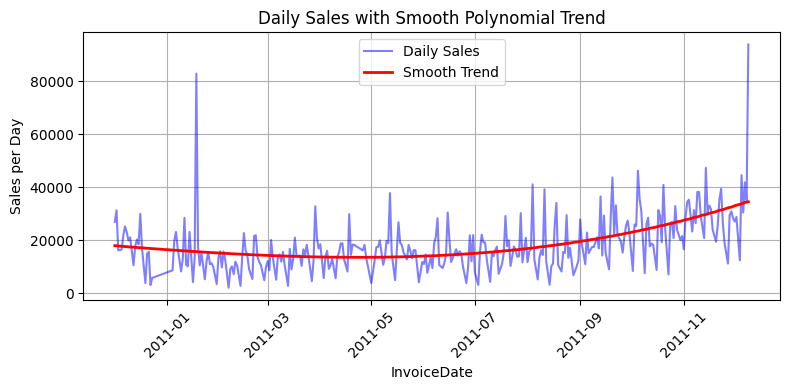

In [48]:
# plotting sales per day

plt.figure(figsize=(8, 4))

# Fit a polynomial (e.g., degree 3 for a cubic polynomial)
degree = 3  # You can adjust the degree for more or less smoothness
sales_coef = np.polyfit(summary['Days'], summary['TotalSales'], degree)

# Create a smooth curve using the polynomial
smooth_days = np.linspace(summary['Days'].min(), summary['Days'].max(), 300)
smooth_sales = np.polyval(sales_coef, smooth_days)

# Convert smooth_days back to datetime for plotting
smooth_dates = [pd.Timestamp.fromordinal(int(day)) for day in smooth_days]

# Plot the original data
plt.plot(summary['InvoiceDate'], summary['TotalSales'], label='Daily Sales', color='blue', alpha=0.5)

# Plot the smooth polynomial curve
plt.plot(smooth_dates, smooth_sales, label='Smooth Trend', color='red', linewidth=2)

# Add labels and legend
plt.xlabel("InvoiceDate")
plt.ylabel("Sales per Day")
plt.title("Daily Sales with Smooth Polynomial Trend")
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

**Note**: Above sales plot doesn't make sense as sales is total sales or quantity we sold not the returns we
are accounting. I will let it be, and leaving this note here for future me. But the revenue below and transaction
makes sense as we have to adjust number of returns and total money we have to return back to customer

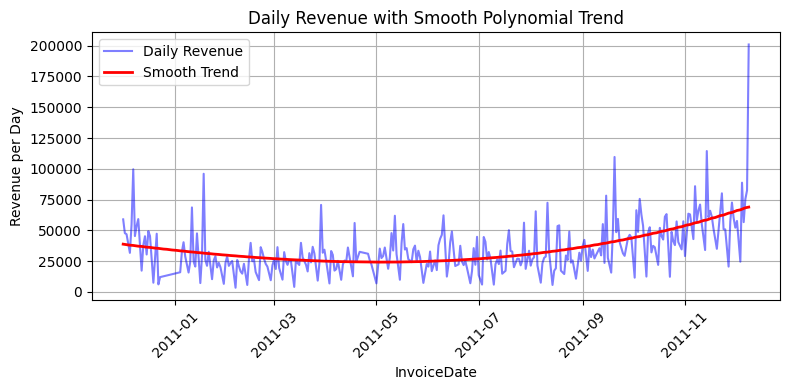

In [50]:
# plotting revenue per day

plt.figure(figsize=(8, 4))

# Fit a polynomial (e.g., degree 3 for a cubic polynomial)
degree = 3  # You can adjust the degree for more or less smoothness
revenue_coef = np.polyfit(summary['Days'], summary['TotalRevenue'], degree)

# Create a smooth curve using the polynomial
smooth_days = np.linspace(summary['Days'].min(), summary['Days'].max(), 300)
smooth_revenue = np.polyval(revenue_coef, smooth_days)

# Convert smooth_days back to datetime for plotting
smooth_dates = [pd.Timestamp.fromordinal(int(day)) for day in smooth_days]

# Plot the original data
"""
temp = np.linspace(summary['TotalRevenue'].min(), summary["TotalRevenue"].max(), 15)
xtemp = [pd.to_datetime("2011-06-14")] * 15
plt.plot(xtemp, temp, color="green")  # date when returns are highest. i.e., total quantity < 0
"""
plt.plot(summary['InvoiceDate'], summary['TotalRevenue'], label='Daily Revenue', color='blue', alpha=0.5)

# Plot the smooth polynomial curve
plt.plot(smooth_dates, smooth_revenue, label='Smooth Trend', color='red', linewidth=2)

# Add labels and legend
plt.xlabel("InvoiceDate")
plt.ylabel("Revenue per Day")
plt.title("Daily Revenue with Smooth Polynomial Trend")
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.savefig("daily_revenue.png")
plt.show()

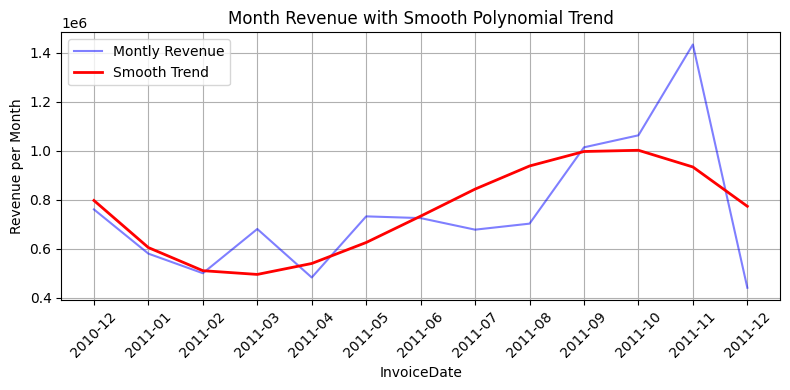

In [44]:
# plotting revenue per day

plt.figure(figsize=(8, 4))

monthlyrev = real_sales.groupby(real_sales["InvoiceDate"].dt.to_period('M'))["TotalPrice"].sum().reset_index()
monthlyrev["months"] = np.arange(monthlyrev["InvoiceDate"].size)

degree = 3
revenue_coef = np.polyfit(monthlyrev['months'], monthlyrev['TotalPrice'], degree)
smooth_revenue = np.polyval(revenue_coef, monthlyrev["months"])

plt.plot(monthlyrev['InvoiceDate'].apply(str), monthlyrev['TotalPrice'], label='Montly Revenue', color='blue', alpha=0.5)
plt.plot(monthlyrev['InvoiceDate'].apply(str), smooth_revenue, label='Smooth Trend', color='red', linewidth=2)

# Add labels and legend
plt.xlabel("InvoiceDate")
plt.ylabel("Revenue per Month")
plt.title("Month Revenue with Smooth Polynomial Trend")
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.savefig("monthly_revenue.png")
plt.show()

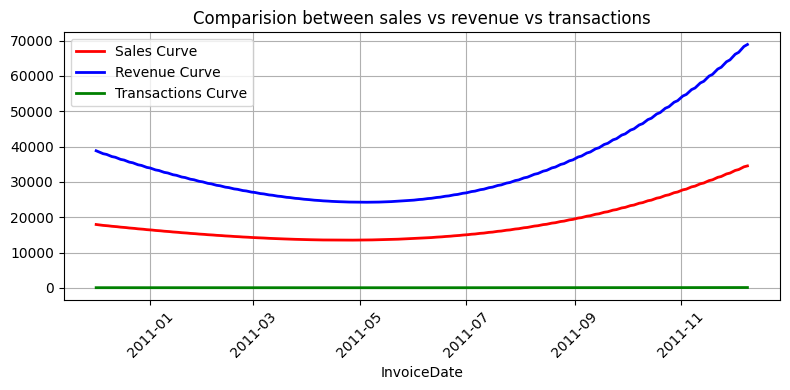

In [51]:
# comparing polynomial curvess

plt.figure(figsize=(8, 4))

plt.plot(smooth_dates, smooth_sales, label='Sales Curve', color='red', linewidth=2)
plt.plot(smooth_dates, smooth_revenue, label='Revenue Curve', color='blue', linewidth=2)
plt.plot(smooth_dates, smooth_trx, label='Transactions Curve', color='green', linewidth=2)

# Add labels and legend
plt.xlabel("InvoiceDate")
plt.title("Comparision between sales vs revenue vs transactions")
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.savefig("comparison.png")
plt.show()

**Overal trend of curves**

- If the sales curve (blue) and revenue curve (red) follow a similar pattern (e.g., both increase or decrease at the same time), it suggests that sales and revenue are strongly correlated. This is common in retail, where higher sales directly lead to higher revenue.

- If the curves diverge significantly, it could indicate that revenue is not directly proportional to sales. This might happen due to:
  - Discounts or promotions: Higher sales volume but lower revenue due to reduced prices.
  - High-value items: Fewer sales but higher revenue due to expensive products.

But this is real_sales subset, so curves won't diverge. As said above about correlation.

**Peaks and Troughs**

- Peaks: If both curves peak at the same time, it indicates seasonal trends or successful marketing campaigns that boosted both sales and revenue.

- Troughs: If both curves dip simultaneously, it could indicate low-demand periods (e.g., holidays, off-seasons) or operational issues (e.g., stockouts).

Looking at above curve, during holiday season both sides are at peak indicating high transaction, sales and thus revenue. It lowers during the off season like summer one.

Also after `2011-07`, all the curves pick up but the revenue one has more slope or incline than other two. Indicating more
pricey stuff is being bought. To understand look at the delta r (revenue) and s (sales) for small time period. Here r > s, if s 
= 1 then r is like 2 or something. Which means having sold one product at price of 2x it's number. which is this overall product
is being priced at 2 something.

Same can be said for sales quantity and number of transaction.

**Divergent Behaviour**

*Future Todo*: Have a mathematical quantity which defines the above divergence when holiday season is coming

**Why those peaks and troughs**

*Future Todo*: Investigate what caused these peaks/troughs (e.g., promotions, holidays, stock issues).

In [76]:
# day when returns are more than sales

summary[summary["TotalSales"] == summary["TotalSales"].min()]

,InvoiceDate,TotalTransactions,TotalSales,TotalRevenue,Days
152,2011-06-14,1581,-13657,39953.82,734302


##### ATV (Average Transaction Value)

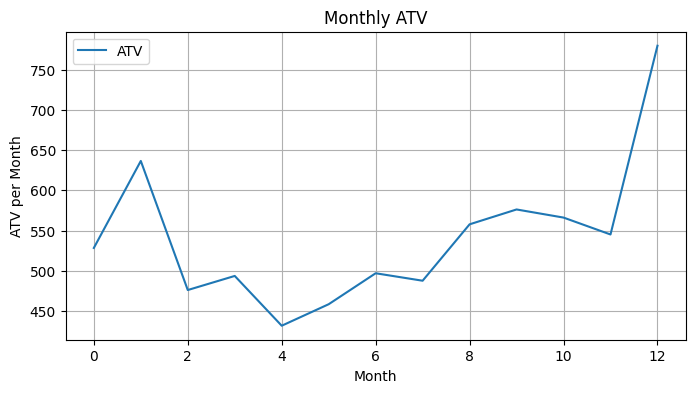

In [89]:
real_sales = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]
atv_data = real_sales.groupby(real_sales["InvoiceDate"].dt.to_period('M')).apply(
    lambda x: x["TotalPrice"].sum() / x["InvoiceNo"].nunique()
).reset_index(name="ATV")
atv_data.plot(kind='line', figsize=(8, 4))
plt.title('Monthly ATV')
plt.xlabel('Month')
plt.ylabel('ATV per Month')
plt.grid(True)
plt.show()

#### Second Question: How is our business growing over time?

##### Growth Rate

In [58]:
# taking returns into account

real_sales = df[~(df["UnitPrice"] < 0)]
stock_series = real_sales["StockCode"]
stock_series = stock_series.astype(str)
real_sales = real_sales[stock_series.str.contains(r'\d', na=False)]

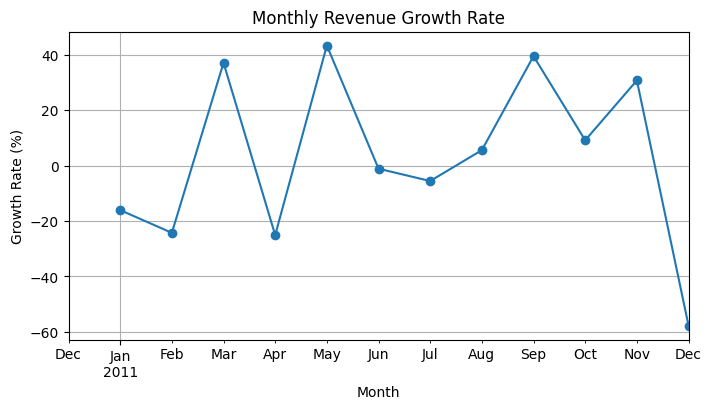

In [100]:
monthly_revenue = real_sales.groupby(df['InvoiceDate'].dt.to_period('M'))['TotalPrice'].sum()
revenue_growth_rate = monthly_revenue.pct_change() * 100

# Plot revenue growth rate
revenue_growth_rate.plot(kind='line', figsize=(8, 4), marker='o')
plt.title('Monthly Revenue Growth Rate')
plt.xlabel('Month')
plt.ylabel('Growth Rate (%)')
plt.grid(True)
plt.show()

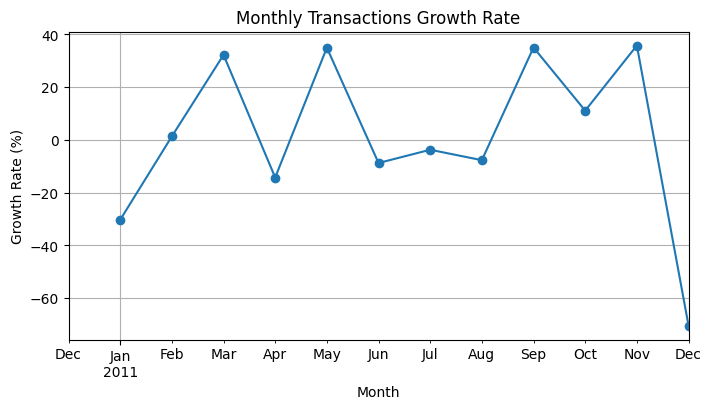

In [93]:
monthly_transactions = real_sales.groupby(df['InvoiceDate'].dt.to_period('M'))['InvoiceNo'].nunique()
transaction_growth_rate = monthly_transactions.pct_change() * 100

transaction_growth_rate.plot(kind='line', figsize=(8, 4), marker='o')
plt.title('Monthly Transactions Growth Rate')
plt.xlabel('Month')
plt.ylabel('Growth Rate (%)')
plt.grid(True)
plt.show()

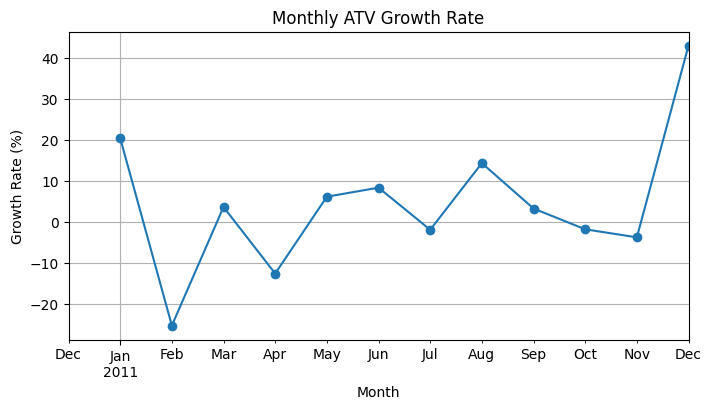

In [98]:
monthly_atv = real_sales.groupby(df['InvoiceDate'].dt.to_period('M')).apply(
    lambda x: x['TotalPrice'].sum() / x['InvoiceNo'].nunique()
)
atv_growth_rate = monthly_atv.pct_change() * 100

atv_growth_rate.plot(kind='line', figsize=(8, 4), marker='o')
plt.title('Monthly ATV Growth Rate')
plt.xlabel('Month')
plt.ylabel('Growth Rate (%)')
plt.grid(True)
plt.show()

In [101]:
revenue_growth_rate

InvoiceDate
2010-12          NaN
2011-01   -16.070677
2011-02   -24.261103
2011-03    37.050354
2011-04   -25.058650
2011-05    43.273274
2011-06    -1.141559
2011-07    -5.581788
2011-08     5.550057
2011-09    39.446272
2011-10     9.105424
2011-11    30.694665
2011-12   -57.681733
Freq: M, Name: TotalPrice, dtype: float64

In [96]:
transaction_growth_rate

InvoiceDate
2010-12          NaN
2011-01   -30.339962
2011-02     1.289134
2011-03    32.181818
2011-04   -14.305365
2011-05    34.911717
2011-06    -8.804283
2011-07    -3.783431
2011-08    -7.728814
2011-09    34.974284
2011-10    11.050626
2011-11    35.735294
2011-12   -70.422535
Freq: M, Name: InvoiceNo, dtype: float64

In [99]:
atv_growth_rate

InvoiceDate
2010-12          NaN
2011-01    20.484176
2011-02   -25.225053
2011-03     3.683212
2011-04   -12.548377
2011-05     6.197799
2011-06     8.402505
2011-07    -1.869072
2011-08    14.391135
2011-09     3.313215
2011-10    -1.751635
2011-11    -3.713573
2011-12    43.076044
Freq: M, dtype: float64